# Faostat global model
In this notebook we create an ensemble of multilayer perceptron ([MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)) models to fit the world crop yields using the input variables: precipitation, air temperature, natural and synthetic fertilizers. The aim of building an ensemble of models is to improve the generalization performance compared to the performance of one single model.

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score 
from time import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import dates
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("Matplotlib version: %s"%mpl.__version__)

NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.8.0


## The dataset
We load the dataset that was prepared by putting into the same file the predictors and the predictands data

In [38]:
global_crop_yield_path = 'data/global_dataset.csv'
global_crop_yield_df = pd.read_csv(global_crop_yield_path, index_col=0)
global_crop_yield_df.head(2)

,Maize (100g/ha),Millet (100g/ha),Temp. Anom. (°C),Prec.Anom. (mm),CO2 (ppm),Manure (Mt),Nitrogen (tons),Phosphate (tons),Potash (tons)
1961-12-31,19423,5925,0.211,15.318908,317.64,1.835092e+10,11486265.27,10888968.81,8626724.57
1962-12-31,19796,5619,0.038,0.768900,318.45,1.872918e+10,12969831.11,11534554.43,9146891.38


## Data preparation
Since the values for the variables differ by orders of magnitude, we normalize them before using the data as input for the model. We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from the scikit-learn package to normalize the values. The scaler removes the mean and scale the values to unit variance. We start by selecting the columns with the input data

In [39]:
MAIZE = 0
MILLET = 1
TEMP_ANOM = 2
PRECIP_ANOM = 3
CO2 = 4
MANURE = 5
NITROGEN = 6
PHOSPHATE = 7
POTASH = 8

In [40]:
X_tmp = global_crop_yield_df.iloc[:, [TEMP_ANOM, PRECIP_ANOM, MANURE, NITROGEN, CO2]].to_numpy()
y_tmp = global_crop_yield_df.iloc[:, [MAIZE]].to_numpy()

In [41]:
num_inputs = X_tmp.shape[1]
num_inputs

5

and the column of the predictand (maize)

In [42]:
y_tmp[:1]

array([[19423]], dtype=int64)

### Data normalization

In [43]:
scaler_x = preprocessing.StandardScaler().fit(X_tmp)

The scaler computes the mean of the input variables

In [44]:
mean_x = scaler_x.mean_[0]
mean_x

0.5707741935483871

and the variance

In [45]:
variance_x = scaler_x.scale_[0]
variance_x

0.5387043721971724

we use the scaler to normalize the input variables

In [46]:
X = scaler_x.transform(X_tmp)
X.shape

(62, 5)

In [47]:
scaler_y = preprocessing.StandardScaler().fit(y_tmp)
y = scaler_y.transform(y_tmp)
y.shape

(62, 1)

In [48]:
mean_y = scaler_y.mean_[0]
mean_y

38951.403225806454

In [49]:
variance_y = scaler_y.scale_[0]
variance_y

11966.558404448891

### Exploratory data analysis
We compute the correlation matrix between the features, then we plot the matrix as a heatmap

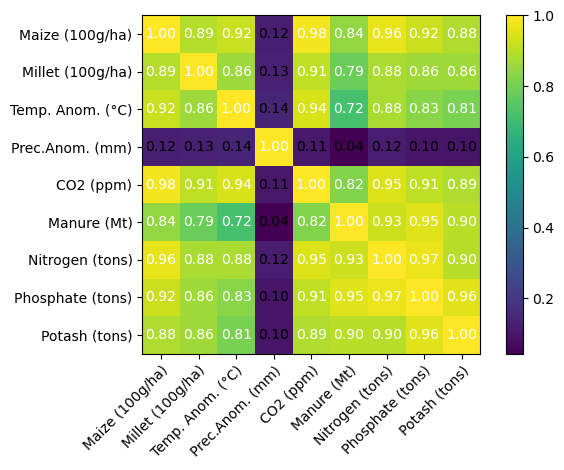

In [50]:
from mlxtend.plotting import heatmap
cm = np.corrcoef(global_crop_yield_df.values.T)
hm = heatmap(cm, row_names=global_crop_yield_df.columns, column_names=global_crop_yield_df.columns)
plt.tight_layout()
plt.show()

## Train and test sets
The data used to train a model of the ensemble is divided into a train set and a test set. The test set will be used after the training to test the performance of the model to predict the values from unseen data. The train set is divided into two subsets: one subset, that is the final training set, and the validation set used during the training phase to update the model's parameters. 

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((49, 5), (49, 1), (13, 5), (13, 1))

## Ensemble models training and validation
The train set created in a previous step will be used to train all the members of the ensemble. Therefore the training set for each member will be randomnly splitted into a train set and a validation set for each member. 

In [52]:
num_observations = X.shape[0]
num_observations

62

We train an ensemble of MLP models that start with a different init parameters

In [53]:
import random 
from random import randint
num_ensemble_members = 20 
random_states = [randint(2, num_observations) for p in range(1, num_ensemble_members + 1)]
len(random_states)

20

A random state is the seed used during the training of a model of the ensemble

In [54]:
print(random_states[:])

[59, 59, 46, 29, 8, 6, 49, 3, 42, 14, 9, 52, 41, 31, 57, 32, 55, 56, 27, 34]


We initialize a 2D array that will contain the predictions of the ensemble models

In [55]:
ensemble_members = np.zeros((num_observations,num_ensemble_members))
ensemble_members.shape

(62, 20)

We define a function for the training and validation of the models for each member of the ensemble.

In [57]:
def ensemble_train_validation(ensemble_members, num_inputs, X, X_train, y_train):
    # This function instantiate an ensemble of MLP models. After the instantiation each
    # ensemble member model is trained and validated on random subset of the training set 
    # passed as an argument to the function. The training set is previously scaled. The full 
    # data set is used to compute the predictions of each ensemble member
    num_ensemble_members = ensemble_members.shape[1]
    for member_id in range(0, num_ensemble_members):
        random_state = random_states[member_id]
        tic = time()
        # Ensemble member model instantiation
        mlp_model = MLPRegressor(
               hidden_layer_sizes=(num_inputs, 1),
               activation='tanh',
               #learning_rate_init=0.01, not used with lbfgs solver
               early_stopping=True,
               random_state=random_state,
               solver='lbfgs',
               max_iter=20
            )
        # Ensemble member model training
        print('Ensemble member {0:d}'.format(member_id))
        X_train_member, X_val, y_train_member, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
        mlp_model.fit(X_train_member, y_train_member)
        print(f"done in {time() - tic:.3f}s")
        # Ensemble member model performances
        member_model_train_score = mlp_model.score(X_train_member, y_train_member)
        print('Train R2 score: {:.2f}'.format(member_model_train_score))
        member_model_validation_score = mlp_model.score(X_val, y_val) 
        print('Validation R2 score: {:.2f}'.format(member_model_validation_score))
        # Ensemble model predictions
        model_sample = mlp_model.predict(X)
        ensemble_members[:, member_id] = model_sample
        mlp_model=None

In [58]:
ensemble_train_validation(ensemble_members, num_inputs, X, X_train, y_train)

Ensemble member 0
done in 0.021s
Train R2 score: 0.98
Validation R2 score: 0.97
Ensemble member 1
done in 0.014s
Train R2 score: 0.98
Validation R2 score: 0.97
Ensemble member 2
done in 0.015s
Train R2 score: 0.99
Validation R2 score: 0.91
Ensemble member 3
done in 0.040s
Train R2 score: 0.99
Validation R2 score: 0.98
Ensemble member 4
done in 0.024s
Train R2 score: 0.98
Validation R2 score: 0.99
Ensemble member 5
done in 0.012s
Train R2 score: 0.99
Validation R2 score: 0.99
Ensemble member 6
done in 0.011s
Train R2 score: 0.98
Validation R2 score: 0.98
Ensemble member 7
done in 0.013s
Train R2 score: 0.97
Validation R2 score: 0.94
Ensemble member 8
done in 0.013s
Train R2 score: 0.97
Validation R2 score: 0.90
Ensemble member 9
done in 0.012s
Train R2 score: 0.93
Validation R2 score: 0.95
Ensemble member 10
done in 0.010s
Train R2 score: 0.99
Validation R2 score: 0.99
Ensemble member 11
done in 0.011s
Train R2 score: 0.99
Validation R2 score: 0.95
Ensemble member 12
done in 0.013s
Trai

In [59]:
ensemble_members.shape

(62, 20)

## Inverse transform
We denormalize the predictions by inverting the predicted values. We can perform the inverse transform using a simple equation

In [60]:
ensemble_denorm = ensemble_members * variance_y + mean_y
#ensemble_denorm[:,0]

or we can use the function provided by the scaler

In [61]:
prediction = scaler_y.inverse_transform(ensemble_members)
#prediction[:, 0]

We can see that there is no difference between the two 

In [62]:
diff = prediction[:, 0] - ensemble_denorm[:,0] == 0
diff.all()

True

## The ensemble dataset
The ensemble dataset is computed as the mean of the predictions of each ensemble members. 

In [63]:
ensemble = prediction.sum(axis=1) / num_ensemble_members
#ensemble

## Linear regression
We build a [linear regression](https://scikit-learn.org/stable/modules/linear_model.html) model to be used as a base reference to compare its performance against the ensemble MLP models. We use the same training set used to train the ensemble models.

In [64]:
linear_regr = linear_model.LinearRegression()
linear_regr.fit(X_train, y_train)
linear_predictions = linear_regr.predict(X)
linear_predictions.shape

(62, 1)

In [65]:
linear_test_predictions = linear_regr.predict(X_test)
linear_rmse = mean_squared_error(linear_test_predictions, y_test)
print('Root mean squared error: {:.2f}'.format(linear_rmse))

Root mean squared error: 0.03


In [66]:
linear_coeffs = linear_regr.coef_
print('Linear regression coefficients: {}'.format(linear_coeffs))

Linear regression coefficients: [[-0.07066157  0.00720829 -0.08469112  0.42149275  0.72558651]]


In [67]:
predictions = scaler_y.inverse_transform(linear_predictions)

## Ensemble model predictions visualization
We use the ensemble 16 with the best test R2 score

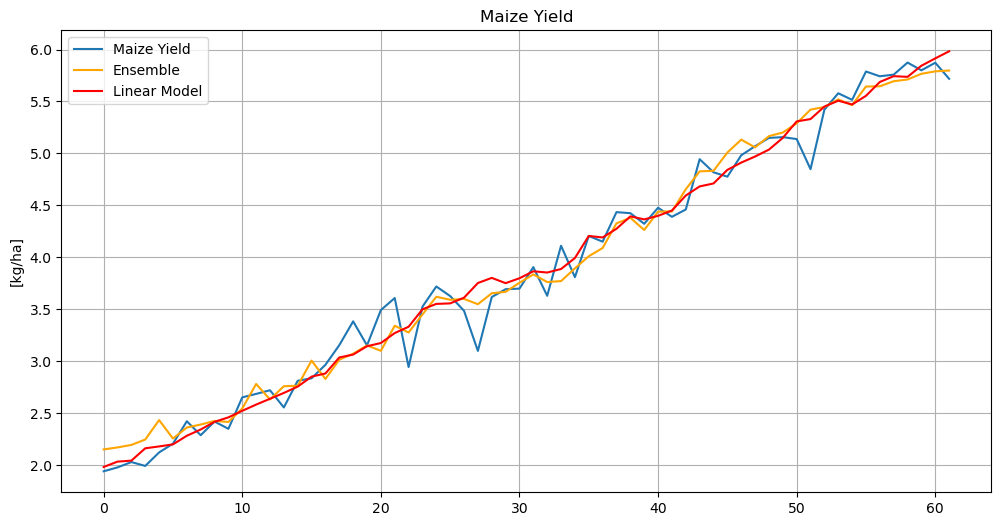

In [68]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yield')
ax.set_ylabel('[kg/ha]');
ax.grid(True, which='both')
pd_maize_yield, = plt.plot(y_tmp / 10000, label='Maize Yield')
pd_ensemble, = plt.plot(ensemble / 10000, label='Ensemble', color='orange')
pd_linear, = plt.plot(predictions / 10000, label='Linear Model', color='red')
plt.legend(handles=[pd_maize_yield, pd_ensemble, pd_linear], loc='upper left')